## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__) 

2.12.0


In [ ]:
!nvidia-smi

Thu Jun 22 09:42:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: HTTP error 404 while getting https://github.com/wandb/client/archive/feature/code-save.zip
ERROR: Could not install requirement https://github.com/wandb/client/archive/feature/code-save.zip because of HTTP error 404 Client Error: Not Found for url: https://codeload.github.com/wandb/wandb/zip/feature/code-save for URL https://github.com/wandb/client/archive/feature/code-save.zip


In [ ]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: skeswarsudhan (skes). Use `wandb login --relogin` to force relogin


True

In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/Manishnadella/Datasets

fatal: destination path 'Datasets' already exists and is not an empty directory.


In [ ]:
# How many training images for SimCLR?
train_images_s = list(paths.list_images("Datasets/Train_augn"))
train_images_n = list(paths.list_images("Datasets/Train_augs"))
print(len(train_images_s))
print(len(train_images_n))

1104
1104


In [ ]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)

        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x

    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x

    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [ ]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds_n = tf.data.Dataset.from_tensor_slices(train_images_n)
train_ds_n = (
    train_ds_n
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_ds_s = tf.data.Dataset.from_tensor_slices(train_images_s)
train_ds_s = (
    train_ds_s
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2023-06-22 09:43:22--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.1’

helpers.py.1        100%[===================>]     891  --.-KB/s    in 0s      

2023-06-22 09:43:22 (54.9 MB/s) - ‘helpers.py.1’ saved [891/891]

--2023-06-22 09:43:22--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

In [ ]:
!pip install augmentation
import tensorflow as tf
import numpy as np



def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)


def gaussian_filter(v1, v2):
    k_size = int(v1.shape[1] * 0.1)  # kernel size is set to be 10% of the image height/width
    gaussian_ope = cv2.GaussianBlur(kernel_size=k_size, min=0.1, max=2.0)
    [v1, ] = tf.py_function(gaussian_ope, [v1], [tf.float32])
    [v2, ] = tf.py_function(gaussian_ope, [v2], [tf.float32])
    return v1, v2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Don't forget to comment the `augmentation` import in the `helpers.py` script.

In [ ]:
!pip install augmentation
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = get_negative_mask(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1)
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
wandb.init(project="simclr")

In [ ]:
def train_simclr(model, datasetn, datasets,optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []
    a=[]
    b=[]

    for epoch in tqdm(range(epochs)):
        for image_batchn in datasetn:
            a.append(image_batchn)
        for image_batchs in datasets:
            b.append(image_batchs)

        for i in range(len(datasetn)//64):
            a1=a[i*64:i*64+64]
            b1=b[i*64:i*64+64]
            loss = train_step(a1, b1, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)


        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds_n, train_ds_s, optimizer, criterion,
                 temperature=0.1, epochs=5)



  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|██        | 1/5 [00:19<01:16, 19.06s/it]

epoch: 1 loss: nan


100%|██████████| 5/5 [01:09<00:00, 13.84s/it]


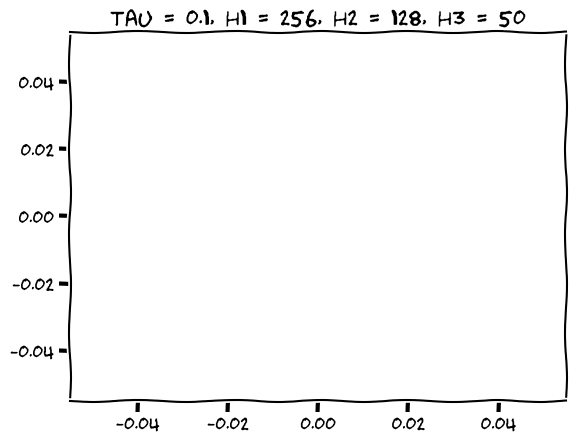

In [ ]:
with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

## Store the weights to a safe place :)

In [ ]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration"
!gcloud config set project $PROJECT_ID

Are you sure you wish to set property [core/project] to fast-ai-exploration?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [ ]:
import datetime
filename ="trial1" + "resnet_simclr.h5"
filename

'trial1resnet_simclr.h5'

In [ ]:
#!gsutil mb gs://resnet_simclr_imagenet
resnet_simclr.save_weights(filename)
!gsutil -m cp 20200508-134915resnet_simclr.h5 gs://resnet_simclr_imagenet/

CommandException: No URLs matched: 20200508-134915resnet_simclr.h5
CommandException: 1 file/object could not be transferred.


## In case saving to a GCS bucket is not possible

In [ ]:
resnet_simclr.save_weights(filename)
wandb.save(filename)

['/content/wandb/run-20230614_052726-ia9m24fg/files/trial1resnet_simclr.h5']